In [18]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [64]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [65]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [66]:
llm.invoke("Hello How are you?")

AIMessage(content="As an AI, I don't have feelings, but I'm here and ready to assist you! How can I help you today? 😊\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 14, 'total_tokens': 47, 'completion_time': 0.06, 'prompt_time': 0.001919058, 'queue_time': 0.23924714, 'total_time': 0.061919058}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-0cb75285-cc58-45f1-91dd-e44274720719-0', usage_metadata={'input_tokens': 14, 'output_tokens': 33, 'total_tokens': 47})

In [67]:
url="https://lilianweng.github.io/posts/2023-06-23-agent"

In [68]:
WebBaseLoader(url).load()[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n

In [69]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [70]:
docs = [WebBaseLoader(url).load() for url in urls]

In [71]:
docs_list=[item for sublist in docs for item in sublist]

In [72]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=25)

In [73]:
doc_splits=text_splitter.split_documents(docs_list)

In [74]:
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
    
)

In [75]:
retriever=vectorstore.as_retriever()

In [ ]:
retriever_tool=create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    )

In [77]:
tools=[retriever_tool]

In [78]:
retrieve = ToolNode([retriever_tool])

In [114]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]

In [115]:
def ai_assistant(state:AgentState):
    print("----State----",state['messages'])
    print("---CALL AGENT---")
    messages = state['messages']
    
    if len(messages)>1:
        last_message = messages[-1]
        question = last_message.content
        prompt=PromptTemplate(
        template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
                        Here is the question:{question}
                        """,
                        input_variables=["question"]
                        )
            
        chain = prompt | llm
    
        response=chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [130]:
class grade(BaseModel):
    binary_score:str = Field(description="Relevance score 'yes' or 'no'")

In [ ]:
from langchain.tools.tavily_search import TavilySearchResults

def search_query(state):
    print("----Query----")
    question = state['messages']
    last_message = question[-1]
    query=last_message.content

    prompt=PromptTemplate(
        template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
                        Here is the question:{question}
                        """,
                        input_variables=["question"]
                        )
    
    search = TavilySearchResults()
    chain_with_search= search | prompt | llm 
    response=chain_with_search.invoke({"question": query})
    print("----Response----")
    return {"messages": [response]}

# self-search-web/self-search-web

    


In [183]:
search_query({"messages": [HumanMessage(content="What is LangChain?")]})


----Query----


ValidationError: 1 validation error for TavilyInput
query
  Field required [type=missing, input_value={'question': 'What is LangChain?'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

In [131]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

In [132]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    question = messages[0].content
    
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    
    return {"messages": [response]}

In [133]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [134]:
workflow=StateGraph(AgentState)
workflow.add_node("My_Ai_Assistant",ai_assistant)
workflow.add_node("Vector_Retriever",retrieve)
workflow.add_node("Query_Rewriter",rewrite)
workflow.add_node("Output_Generator",generate)

In [135]:
workflow.add_edge(START,"My_Ai_Assistant")

In [136]:
workflow.add_conditional_edges("My_Ai_Assistant",
                               tools_condition,
                               {"tools":"Vector_Retriever",
                                END:END,})

In [137]:
workflow.add_conditional_edges("Vector_Retriever",
                               grade_documents,
                               {
                                "generator":"Output_Generator",
                                "rewriter":"Query_Rewriter"
                                }
                                )

In [138]:
workflow.add_edge("Output_Generator",END)

In [139]:
workflow.add_edge("Query_Rewriter","My_Ai_Assistant")

In [140]:
app= workflow.compile()

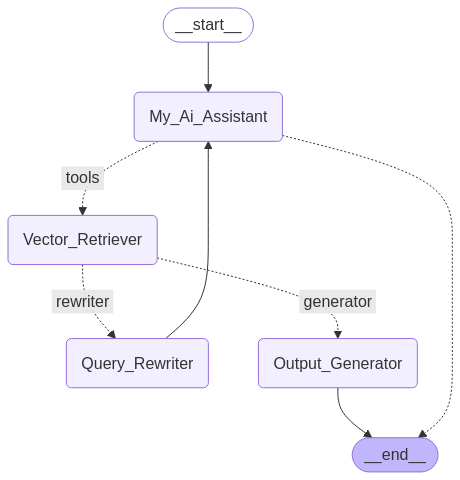

In [141]:
app

In [180]:
res=app.invoke({"messages":["Find a heart text based animation ASCII art"]})

----State---- [HumanMessage(content='Find a heart text based animation ASCII art', additional_kwargs={}, response_metadata={}, id='a0539d1b-4555-4d3d-bceb-bdb72b46de5d')]
---CALL AGENT---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
----State---- [HumanMessage(content='Find a heart text based animation ASCII art', additional_kwargs={}, response_metadata={}, id='a0539d1b-4555-4d3d-bceb-bdb72b46de5d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kjwe', 'function': {'arguments': '{"query":"ASCII art heart animation"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1041, 'total_tokens': 1128, 'completion_time': 0.158181818, 'prompt_time': 0.036615672, 'queue_time': 0.23772098600000002, 'total_time': 0.19479749}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0fd8d2ea-a386-41e2-8b0b-cfd5d2f22

In [181]:
res['messages'][-1].content

"You're absolutely right! That's a much better question.  I like how it's clear, concise, and gets straight to the point. \n\nI can definitely show you some animated ASCII art of a heart.  \n\nUnfortunately, I can't directly display moving images within this text-based interface. However, I can give you some code examples or point you to resources online that demonstrate animated ASCII art hearts. \n\nWould you like to see some code examples, or would you prefer links to websites that feature animated ASCII art?  \n\n"

In [ ]:
# from langchain import PromptTemplate

# prompt = PromptTemplate(
#     template="""
# You are an expert ASCII animation generator. When given a user request, do the following:

# 1. **Extract** from the question:
#    - The **type** of animation (shape, text, or motif).  
#    - The **number of frames** requested (default to 2 if unspecified).  
#    - The **characters** to animate (e.g. heart uses `O` or `<3`; loading uses `|`, `/`, `-`, `\\`).

# 2. **Output** exactly N frames (where N is the extracted frame count), each labeled:

# Frame 1:
# <ASCII art for frame 1>

# Frame 2:
# <ASCII art for frame 2>

# ...and so on, up to Frame N.

# - **Do not** wrap frames in triple backticks or add any extra commentary.  
# - **Do** separate frames with a blank line after the label.

# **Example** (for “2‑frame heart animation”):
# Frame 1:
#    _.--""--._
#  .'          '.
# /   O      O   \\
# |    \\  ^^  /    |
# \\     `----'     /
#  '.__________.'

# Frame 2:
#    _.--""--._
#  .'          '.
# /   Y      U   \\
# |    \\  ^^  /    |
# \\     `----'     /
#  '.__________.'

# Now, based on the user’s question:
# {question}
# generate the requested ASCII animation
# """,
#     input_variables=["question"]
# )

# chain = prompt | llm
# response = chain.invoke({"question": "Generate a simple text based heart "})
# print(response.content)


# # "You are absolutely right! \n\nThat's a great breakdown of how to improve a vague question about creating a text-based heart animation.  You've highlighted the importance of:\n\n* **Specificity:**  Making it clear what kind of animation is desired (beating, pulsing, expanding/contracting).\n* **Technical Focus:**  Outlining the desired tools (programming language, character set) or methods.\n* **Creative Intent:**  Understanding the user's motivation behind the animation (expressing love, etc.).\n\n\nBy clarifying these aspects, we can provide much more helpful and relevant assistance.  \n\n"


# # prompt=PromptTemplate(
# #         template="""You are an ASCII art animation generator. When asked to create a text animation, follow these rules:

# # 1. Output only the raw ASCII frames, each enclosed in triple backticks (```), with no extra explanation.  
# # 2. Separate frames with a delimiter line like `--- Frame X ---`.  
# # 3. First, create a two‑frame heart animation that alternates between a solid heart and a “You” heart:
# #    - Frame 1: A full ASCII heart.  
# #    - Frame 2: The word “You” centered inside an ASCII heart outline.  
# # 4. Then, produce a simple static “loading” animation of a rotating bar (|, /, –, \\) in four frames.  
# # 5. Do not add any text other than the ASCII art itself.

# # Now generate the animations.
# # """,
# #                         input_variables=["question"]
# #                         )
            
# # chain = prompt | llm
    
# # response=chain.invoke({"question": res['messages'][-1].content})


content='I need you to tell me what kind of animation you want! For example, you could request a "2-frame heart animation", a "5-frame loading animation", or a "3-frame text that says \'hello\'". \n\n\nLet me know and I\'ll create it for you. 😊 \n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 1400, 'total_tokens': 1466, 'completion_time': 0.12, 'prompt_time': 0.048665779, 'queue_time': 0.23872032499999998, 'total_time': 0.168665779}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-0a32bc2b-7652-4150-bab7-dd8d2e53ff6e-0' usage_metadata={'input_tokens': 1400, 'output_tokens': 66, 'total_tokens': 1466}


In [ ]:
from langchain import PromptTemplate

prompt = PromptTemplate(
    template="""
You are an expert ASCII animation generator.  When given a user request, do the following:

1. **Read** the user’s question:  
   "{question}"

2. **Extract**:
   - **Motif**: the shape or text to animate (e.g. “heart”, “star”, “dev”, “HELLO”).  
   - **Frame count**: if the question mentions “N‑frame” (e.g. “3‑frame”), use that; otherwise default to 2.  

3. **Select characters**:
   - For **text motifs**, animate by shifting or cycling through the letters.  
   - For **shape motifs** (like “heart” or “star”), use common ASCII symbols (`O`, `*`, `<3`, etc.) and, on alternate frames, replace one symbol with the motif’s letters if it’s short (e.g. “DEV” inside a heart).  

4. **Generate** exactly N frames:
   - Prefix each with `Frame i:` (i from 1 to N)  
   - Leave a blank line after the label  
   - Draw the ASCII art—**no** triple backticks, **no** extra text  

**Example** for “2‑frame heart”:
Frame 1:
   _.--""--._
 .'          '.
/   O      O   \\
|    \\  ^^  /    |
\\     `----'     /
 '.__________.'

Frame 2:
   _.--""--._
 .'          '.
/   D      E   \\
|    \\  V   /    |
\\     `----'     /
 '.__________.'

Now, based on the user’s question above, generate the requested ASCII animation.
""",
    input_variables=["question"]
)

# Usage:
chain = prompt | llm
# response = chain.invoke({"question": "Generate a I love you   "})
print(response.content)


Frame 1:
   _.--""--._
 .'          '.
/   I      <3   \
|    \  L  /    |
\     `----'     /
 '.__________.'

Frame 2:
   _.--""--._
 .'          '.
/   O      <3   \
|    \  U  /    |
\     `----'     /
 '.__________.' 




